In [1]:
# ------- TEST function of mapping --------- # 

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import glob
import os
import waypoint_distance as wd
%matplotlib widget

def plot_multiple_missions_map(glider_files, long_bounds=None, lat_bounds=None,
                               topo_file=os.path.expanduser('~/Desktop/british_columbia_3_msl_2013.nc')):
    """
    Plot multiple glider paths over bathymetry for the Calvert Line.

    Parameters:
    - glider_files: list of str, paths to NetCDF glider grid files
    - topo_file: str, path to topo NetCDF file
    - long_bounds, lat_bounds: optional map bounds
    """

    # Load all datasets
    datasets = [xr.open_dataset(os.path.expanduser(f)) for f in glider_files]
    all_lons = np.concatenate([ds['longitude'].values for ds in datasets])
    all_lats = np.concatenate([ds['latitude'].values for ds in datasets])

    # Auto bounding box if not provided
    if long_bounds is None:
        long_bounds = [all_lons.min() - 0.5, all_lons.max() + 0.5]
    if lat_bounds is None:
        lat_bounds = [all_lats.min() - 0.5, all_lats.max() + 0.5]

    # Load topo and subset
    topo = xr.open_dataset(topo_file)
    topo = topo.sel(
        lon=slice(long_bounds[0], long_bounds[1]),
        lat=slice(lat_bounds[0], lat_bounds[1])
    )
    topo_var = -topo['Band1']

    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(long_bounds + lat_bounds, crs=ccrs.PlateCarree())

    # Gridlines with lat/lon ticks only
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Bathymetry shading
    levels = np.linspace(0, 410, 51)
    contourf = ax.contourf(topo['lon'], topo['lat'], topo_var,
                           levels=levels, cmap=cm.cm.deep, extend='both')
    fig.colorbar(contourf, ax=ax, label='Depth (m)')

    # 0 m contour (coastline)
    ax.contour(topo['lon'], topo['lat'], topo_var, levels=[0.5], colors='black', linewidths=1)

    # Time scaling for consistent colorbar
    all_time_vals = np.concatenate([ds['time'].values for ds in datasets])
    all_time_nums = mdates.date2num(all_time_vals)
    vmin = all_time_nums.min()
    vmax = all_time_nums.max()

    for i, ds in enumerate(datasets):
        lons = ds['longitude'].values
        lats = ds['latitude'].values
        time_vals = ds['time'].values
        time_nums = mdates.date2num(time_vals)

        label = os.path.basename(glider_files[i]).split('_')[0]
        sc = ax.scatter(lons, lats, c=time_nums, cmap='seismic',
                        vmin=vmin, vmax=vmax, s=5, transform=ccrs.PlateCarree(),
                        zorder=5, label=label)

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.01, extend='both')
    cbar.set_label('Date')
    cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Waypoint track overlay (optional)
    waypoint_lon = [-127.950, -128.115, -128.243, -128.514, -128.646, -128.798]
    waypoint_lat = [51.757, 51.705, 51.715, 51.450, 51.4165, 51.408]
    # ax.plot(waypoint_lon, waypoint_lat, color='black', linestyle='-', linewidth=2, label='Transect')

    ax.legend(title='Glider Missions')
    ax.set_title('Glider Missions Map')
    ax.set_aspect(1 / np.cos(np.deg2rad(np.mean(lat_bounds))))

# Function to compare glider data:
def plot_comparison_map(original_file, reprocessed_file,
                        long_bounds=None, lat_bounds=None,
                        topo_file=os.path.expanduser('~/CalvertLine/smith_sandwell_topo_v8_2.nc')):
    """
    Plot original vs reprocessed glider path on a topo map.

    Parameters:
    - original_file: str, path to original _grid_delayed.nc file
    - reprocessed_file: str, path to reprocessed _grid_delayed.nc file
    - long_bounds, lat_bounds: optional map bounds
    - topo_file: str, path to Smith & Sandwell topo NetCDF
    """
    import xarray as xr
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np
    import os
    import cmocean

    # Load datasets
    ds_old = xr.open_dataset(os.path.expanduser(original_file))
    ds_new = xr.open_dataset(os.path.expanduser(reprocessed_file))

    # Autoscale bounds if needed
    all_lons = np.concatenate([ds_old.longitude.values, ds_new.longitude.values])
    all_lats = np.concatenate([ds_old.latitude.values, ds_new.latitude.values])

    if long_bounds is None:
        long_bounds = [all_lons.min() - 0.5, all_lons.max() + 0.5]
    if lat_bounds is None:
        lat_bounds = [all_lats.min() - 0.5, all_lats.max() + 0.5]

    # Load topo
    topo = xr.open_dataset(topo_file)
    topo = topo.sel(
        longitude=slice(long_bounds[0] + 360, long_bounds[1] + 360),
        latitude=slice(lat_bounds[0], lat_bounds[1]))
    topo['longitude'] = topo['longitude'] - 360  # Convert to west longitudes

    # Set up map
    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    ax.set_extent(long_bounds + lat_bounds, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_aspect(1 / np.cos(np.deg2rad(np.mean(lat_bounds))))

    # Plot bathymetry
    topo_var = -topo['ROSE']
    levels = np.linspace(0, 4500, 21)
    contour = ax.contourf(topo['longitude'], topo['latitude'], topo_var,
                          levels=levels, cmap=cmocean.cm.deep, extend='both')
    plt.colorbar(contour, ax=ax, label='Depth (m)')

    # Plot glider tracks in fixed colors
    ax.scatter(ds_old.longitude, ds_old.latitude, color='red', label='Original Track', s=5)
    ax.scatter(ds_new.longitude, ds_new.latitude, color='blue', label='Reprocessed Track', s=1)

    # # Add waypoint transect (optional)
    # waypoint_lon = [-127.950, -128.115, -128.243, -128.514, -128.646, -128.798]
    # waypoint_lat = [51.757, 51.705, 51.715, 51.450, 51.4165, 51.408]
    # ax.plot(waypoint_lon, waypoint_lat, color='black', linestyle='--', linewidth=2, label='Waypoint Transect')

    # Extract glider name from file path
    glider_name = os.path.basename(original_file).split('_')[0]

    # Finalize plot
    ax.legend(title=f'Track Comparison for {glider_name}')
    plt.title(f'Original vs Reprocessed Glider Track: {glider_name}')

    plt.show()

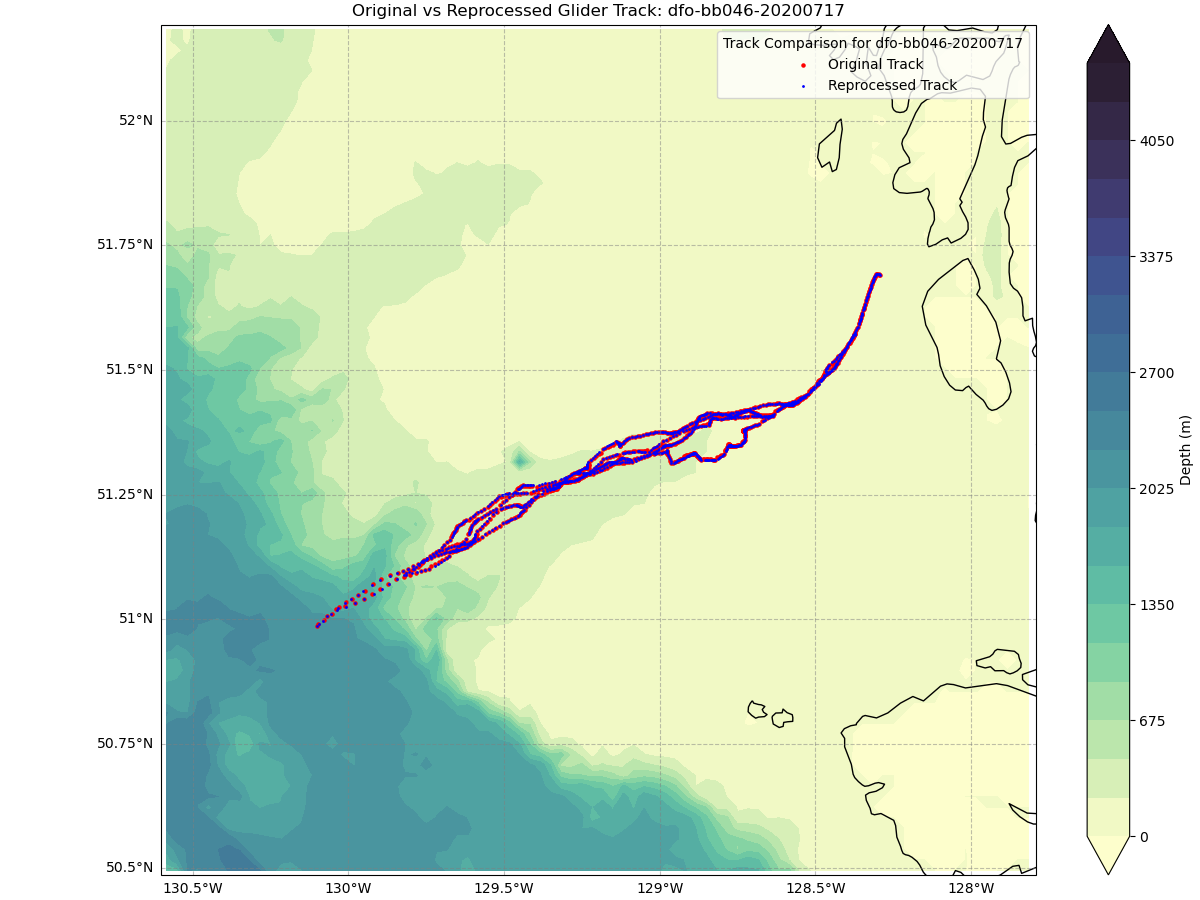

In [2]:
plot_comparison_map(
    original_file='/Users/martinwilliamson/CalvertLine/dfo-bb046-20200717_grid_delayed.nc',
    reprocessed_file='~/CalvertLine_reprocessed/dfo-bb046-20200717_grid_delayed.nc')

In [1]:
import os

reprocessed_dir = os.path.expanduser('~/CalvertLine_reprocessed')
original_dir = os.path.expanduser('~/CalvertLine')

# List all _grid_delayed.nc files in both directories
reprocessed_files = sorted([
    f for f in os.listdir(reprocessed_dir) if f.endswith('_grid_delayed.nc')
])
original_files = sorted([
    f for f in os.listdir(original_dir) if f.endswith('_grid_delayed.nc')
])

# Find filenames present in both directories
matched_files = sorted(set(reprocessed_files) & set(original_files))

# Loop over matched files and run the plot function
for filename in matched_files:
    reprocessed_path = os.path.join(reprocessed_dir, filename)
    original_path = os.path.join(original_dir, filename)

    print(f"Plotting comparison for {filename}")
    plot_comparison_map(original_path, reprocessed_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/martinwilliamson/CalvertLine'

In [4]:
import os
import pandas as pd

original_dir = os.path.expanduser('~/CalvertLine')
reprocessed_dir = os.path.expanduser('~/CalvertLine_reprocessed')

# Get files ending with _grid_delayed.nc in both dirs
orig_files = {
    f: os.path.getsize(os.path.join(original_dir, f))
    for f in os.listdir(original_dir)
    if f.endswith('_grid_delayed.nc')
}
reproc_files = {
    f: os.path.getsize(os.path.join(reprocessed_dir, f))
    for f in os.listdir(reprocessed_dir)
    if f.endswith('_grid_delayed.nc')
}

# Create DataFrame comparing sizes
all_files = sorted(set(orig_files.keys()) | set(reproc_files.keys()))
data = []
for f in all_files:
    orig_size = orig_files.get(f, None)
    reproc_size = reproc_files.get(f, None)
    diff = (reproc_size - orig_size) if (orig_size and reproc_size) else None
    data.append((f, orig_size, reproc_size, diff))

df = pd.DataFrame(data, columns=['Filename', 'Original (bytes)', 'Reprocessed (bytes)', 'Difference'])

df

,Filename,Original (bytes),Reprocessed (bytes),Difference
0,dfo-bb046-20200717_grid_delayed.nc,161394726,161081169.0,-313557.0
1,dfo-bb046-20200810_grid_delayed.nc,129546678,129550017.0,3339.0
2,dfo-bb046-20200908_grid_delayed.nc,143806998,144761025.0,954027.0
3,dfo-bb046-20201006_grid_delayed.nc,142064074,142064074.0,0.0
4,dfo-bb046-20201103_grid_delayed.nc,142222540,142222540.0,0.0
5,dfo-bb046-20210212_grid_delayed.nc,198946924,198946924.0,0.0
6,dfo-bb046-20210324_grid_delayed.nc,128120668,128123999.0,3331.0
7,dfo-bb046-20210413_grid_delayed.nc,163454572,163457903.0,3331.0
8,dfo-bb046-20210511_grid_delayed.nc,154884738,154884329.0,-409.0
9,dfo-bb046-20220608_grid_delayed.nc,108473123,108793344.0,320221.0


In [5]:
import xarray as xr
import numpy as np

# File paths
file1 = os.path.expanduser('~/CalvertLine/dfo-bb046-20200717_grid_delayed.nc')
file2 = os.path.expanduser('~/CalvertLine_reprocessed/dfo-bb046-20200717_grid_delayed.nc')

# Load datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# 1. Global attributes
print("🔹 Global attribute differences:")
for key in set(ds1.attrs) | set(ds2.attrs):
    if ds1.attrs.get(key) != ds2.attrs.get(key):
        print(f"  {key}:\n    file1: {ds1.attrs.get(key)}\n    file2: {ds2.attrs.get(key)}")

# 2. Variable presence
vars1 = set(ds1.variables)
vars2 = set(ds2.variables)
print("\n🔹 Variables only in file1:", vars1 - vars2)
print("🔹 Variables only in file2:", vars2 - vars1)

# 3. Compare shapes and data values
shared_vars = vars1 & vars2
for var in sorted(shared_vars):
    v1 = ds1[var]
    v2 = ds2[var]
    if v1.shape != v2.shape:
        print(f"\n⚠️ Shape mismatch in '{var}': {v1.shape} vs {v2.shape}")
    else:
        # Try numeric comparison
        try:
            diff = np.abs(v1.values - v2.values)
            if np.nanmax(diff) > 1e-6:
                print(f"\n🔹 Values differ in '{var}': max diff = {np.nanmax(diff):.2e}")
        except:
            if not np.array_equal(v1.values, v2.values):
                print(f"\n🔹 Non-numeric values differ in '{var}'")

# 4. Check for missing values
for var in sorted(shared_vars):
    nan1 = np.isnan(ds1[var].values).sum() if np.issubdtype(ds1[var].dtype, np.floating) else 0
    nan2 = np.isnan(ds2[var].values).sum() if np.issubdtype(ds2[var].dtype, np.floating) else 0
    if nan1 != nan2:
        print(f"\n🔹 NaN count differs in '{var}': file1={nan1}, file2={nan2}")

🔹 Global attribute differences:
  geospatial_lat_max:
    file1: 51.69336666666666
    file2: 51.69336661034395
  deployment_start:
    file1: 2020-07-17T16:28:43.726000000
    file2: 2020-07-17T16:28:43
  time_coverage_start:
    file1: 2020-07-17T16:28:43.726000000
    file2: 2020-07-17T16:28:43
  Conventions:
    file1: CF-1.6
    file2: CF-1.8
  cdm_data_type:
    file1: Trajectory
    file2: None
  time_coverage_end:
    file1: 2020-08-06T21:32:24.865000000
    file2: 2020-08-06T21:32:24
  geospatial_lat_min:
    file1: 50.9822
    file2: 50.98220006734734
  geospatial_lon_min:
    file1: -130.11181666666667
    file2: -130.11181654513223
  standard_name_vocabulary:
    file1: CF Standard Name Table v49
    file2: CF STandard Name Table v72
  deployment_end:
    file1: 2020-08-06T21:32:24.865000000
    file2: 2020-08-06T21:32:24
  date_issued:
    file1: 2023-05-01T17:38:53Z
    file2: 2025-05-23T21:32:12Z
  date_created:
    file1: 2023-05-01T17:38:53Z
    file2: 2025-05-23T21:32

In [6]:
import xarray as xr
import numpy as np
import os

# File paths
file1 = os.path.expanduser('~/CalvertLine/dfo-bb046-20200908_grid_delayed.nc')
file2 = os.path.expanduser('~/CalvertLine_reprocessed/dfo-bb046-20200908_grid_delayed.nc')

# Load datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# 1. Global attribute differences
print("🔹 Global attribute differences:")
for key in set(ds1.attrs) | set(ds2.attrs):
    if ds1.attrs.get(key) != ds2.attrs.get(key):
        print(f"  {key}:\n    file1: {ds1.attrs.get(key)}\n    file2: {ds2.attrs.get(key)}")

# 2. Variable presence
vars1 = set(ds1.variables)
vars2 = set(ds2.variables)
print("\n🔹 Variables only in file1:", vars1 - vars2)
print("🔹 Variables only in file2:", vars2 - vars1)

# 3. Compare shapes and data values
shared_vars = vars1 & vars2
for var in sorted(shared_vars):
    v1 = ds1[var]
    v2 = ds2[var]
    if v1.shape != v2.shape:
        print(f"\n⚠️ Shape mismatch in '{var}': {v1.shape} vs {v2.shape}")
    else:
        try:
            diff = np.abs(v1.values - v2.values)
            if np.nanmax(diff) > 1e-6:
                print(f"\n🔹 Values differ in '{var}': max diff = {np.nanmax(diff):.2e}")
        except:
            if not np.array_equal(v1.values, v2.values):
                print(f"\n🔹 Non-numeric values differ in '{var}'")

# 4. NaN comparison
for var in sorted(shared_vars):
    if np.issubdtype(ds1[var].dtype, np.floating):
        nan1 = np.isnan(ds1[var].values).sum()
        nan2 = np.isnan(ds2[var].values).sum()
        if nan1 != nan2:
            print(f"\n🔹 NaN count differs in '{var}': file1={nan1}, file2={nan2}")

🔹 Global attribute differences:
  geospatial_lat_max:
    file1: 51.72575
    file2: 51.724399999999996
  deployment_start:
    file1: 2020-09-08T13:36:39.635000000
    file2: 2020-09-08T13:36:39
  time_coverage_start:
    file1: 2020-09-08T13:36:39.635000000
    file2: 2020-09-08T13:36:39
  Conventions:
    file1: CF-1.6
    file2: CF-1.8
  cdm_data_type:
    file1: Trajectory
    file2: None
  time_coverage_end:
    file1: 2020-09-30T23:28:25.292000000
    file2: 2020-09-30T23:28:25
  geospatial_lat_min:
    file1: 50.985866666666666
    file2: 50.9868503450144
  geospatial_lon_min:
    file1: -130.40183333333334
    file2: -130.40184926474547
  standard_name_vocabulary:
    file1: CF Standard Name Table v49
    file2: CF STandard Name Table v72
  deployment_end:
    file1: 2020-09-30T23:28:25.292000000
    file2: 2020-09-30T23:28:25
  date_issued:
    file1: 2023-05-18T21:18:28Z
    file2: 2025-05-23T23:57:05Z
  date_created:
    file1: 2023-05-18T21:18:28Z
    file2: 2025-05-23T23:

In [7]:
import xarray as xr
import numpy as np
import os

# File paths
file1 = os.path.expanduser('~/CalvertLine/dfo-marvin1003-20221018_grid_delayed.nc')
file2 = os.path.expanduser('~/CalvertLine_reprocessed/dfo-marvin1003-20221018_grid_delayed.nc')

# Load datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# 1. Global attribute differences
print("🔹 Global attribute differences:")
for key in set(ds1.attrs) | set(ds2.attrs):
    if ds1.attrs.get(key) != ds2.attrs.get(key):
        print(f"  {key}:\n    file1: {ds1.attrs.get(key)}\n    file2: {ds2.attrs.get(key)}")

# 2. Variable presence
vars1 = set(ds1.variables)
vars2 = set(ds2.variables)
print("\n🔹 Variables only in file1:", vars1 - vars2)
print("🔹 Variables only in file2:", vars2 - vars1)

# 3. Compare shapes and data values
shared_vars = vars1 & vars2
for var in sorted(shared_vars):
    v1 = ds1[var]
    v2 = ds2[var]
    if v1.shape != v2.shape:
        print(f"\n⚠️ Shape mismatch in '{var}': {v1.shape} vs {v2.shape}")
    else:
        try:
            diff = np.abs(v1.values - v2.values)
            if np.nanmax(diff) > 1e-6:
                print(f"\n🔹 Values differ in '{var}': max diff = {np.nanmax(diff):.2e}")
        except:
            if not np.array_equal(v1.values, v2.values):
                print(f"\n🔹 Non-numeric values differ in '{var}'")

# 4. NaN comparison
for var in sorted(shared_vars):
    if np.issubdtype(ds1[var].dtype, np.floating):
        nan1 = np.isnan(ds1[var].values).sum()
        nan2 = np.isnan(ds2[var].values).sum()
        if nan1 != nan2:
            print(f"\n🔹 NaN count differs in '{var}': file1={nan1}, file2={nan2}")

🔹 Global attribute differences:
  geospatial_lat_max:
    file1: 51.75632006074588
    file2: 51.75635155909015
  deployment_start:
    file1: 2022-10-18T17:40:07.000000000
    file2: 2022-10-18T17:40:07
  time_coverage_start:
    file1: 2022-10-18T17:40:07.000000000
    file2: 2022-10-18T17:40:07
  Conventions:
    file1: CF-1.6
    file2: CF-1.8
  cdm_data_type:
    file1: Trajectory
    file2: None
  time_coverage_end:
    file1: 2022-11-25T23:46:45.000000000
    file2: 2022-11-25T23:46:45
  geospatial_lat_min:
    file1: 49.685738405181205
    file2: 49.68573841149077
  geospatial_lon_min:
    file1: -133.6709646240772
    file2: -133.66255935763
  standard_name_vocabulary:
    file1: CF Standard Name Table v49
    file2: CF STandard Name Table v72
  creator_url:
    file1: http://cproof.uvic.ca
    file2: https://cproof.uvic.ca
  deployment_end:
    file1: 2022-11-25T23:46:45.000000000
    file2: 2022-11-25T23:46:45
  date_issued:
    file1: 2023-02-24T20:06:48Z
    file2: 2025-06

In [1]:
import os
# Which files are not in both directories? 


reprocessed_dir = os.path.expanduser('~/CalvertLine_reprocessed')
original_dir = os.path.expanduser('~/CalvertLine')

# List all _grid_delayed.nc files in both directories
reprocessed_files = set([
    f for f in os.listdir(reprocessed_dir) if f.endswith('_grid_delayed.nc')
])
original_files = set([
    f for f in os.listdir(original_dir) if f.endswith('_grid_delayed.nc')
])

# Files missing in either direction
only_in_reprocessed = sorted(reprocessed_files - original_files)
only_in_original = sorted(original_files - reprocessed_files)

# Print differences
if only_in_reprocessed:
    print("Files only in reprocessed directory:")
    for f in only_in_reprocessed:
        print(f"  {f}")

if only_in_original:
    print("Files only in original directory:")
    for f in only_in_original:
        print(f"  {f}")

# Optional: matched files if needed
matched_files = sorted(reprocessed_files & original_files)

Files only in original directory:
  dfo-hal1002-20220804_grid_delayed.nc
